# VR - Motion recognition with simple gestures

## Libraries
* Numpy
* Pandas
* Matplotlib
* PyTorch

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.onnx

from xgboost import XGBClassifier

## Importing scripts

In [2]:
from utils.data import Data
from utils.hardware import Hardware
from utils.model import VRGestureRecognizer
from utils.plot import Plot

## Loading data

We first begin by loading all the data from the csv files. We retrieve **all the raw data** into **a single numpy array**. We retrieve the **labels** into **a separate array**.

In [3]:
# Define base data directory
base_dir: str = os.path.join(os.getcwd(), 'data')

# Load data
tuple_data: tuple[np.ndarray, np.ndarray, np.ndarray] = Data.load_data(base_dir)

# Unpack data
data: np.ndarray = tuple_data[0]
labels: np.ndarray = tuple_data[1]
classes: np.ndarray = tuple_data[2]
print("Classes:", classes)

Classes: ['OUI' 'NON' 'VRAI' 'FAUX']


## Settings and hyperparameters ...

Here we define the **settings** and **hyperparameters** for the model. Here are the ones we will use for our use case:
* Device: the device on which the model will be trained. We will use a GPU if available, otherwise we will use the CPU.
* Batch size: the number of samples that will be propagated through the network at once.
* Number of epochs: the number of times the entire dataset will be passed through the network.
* Learning rate: the step size at each iteration while moving toward a minimum of a loss function.
* Hidden size: the size of the hidden layer in the fully connected part of the network.
* Number of labels: the number of labels in the dataset.

In [4]:
DEVICE = Hardware.device()
BATCH_SIZE = 16
EPOCHS = 100
LEARNING_RATE = 1e-4
HIDDEN_SIZE = 128
NUM_LABELS = classes.shape[0]

# Loss function
loss_fn = nn.CrossEntropyLoss()

## Model - Convolutional Neural Network

### Training

  0%|          | 0/100 [00:00<?, ?it/s]

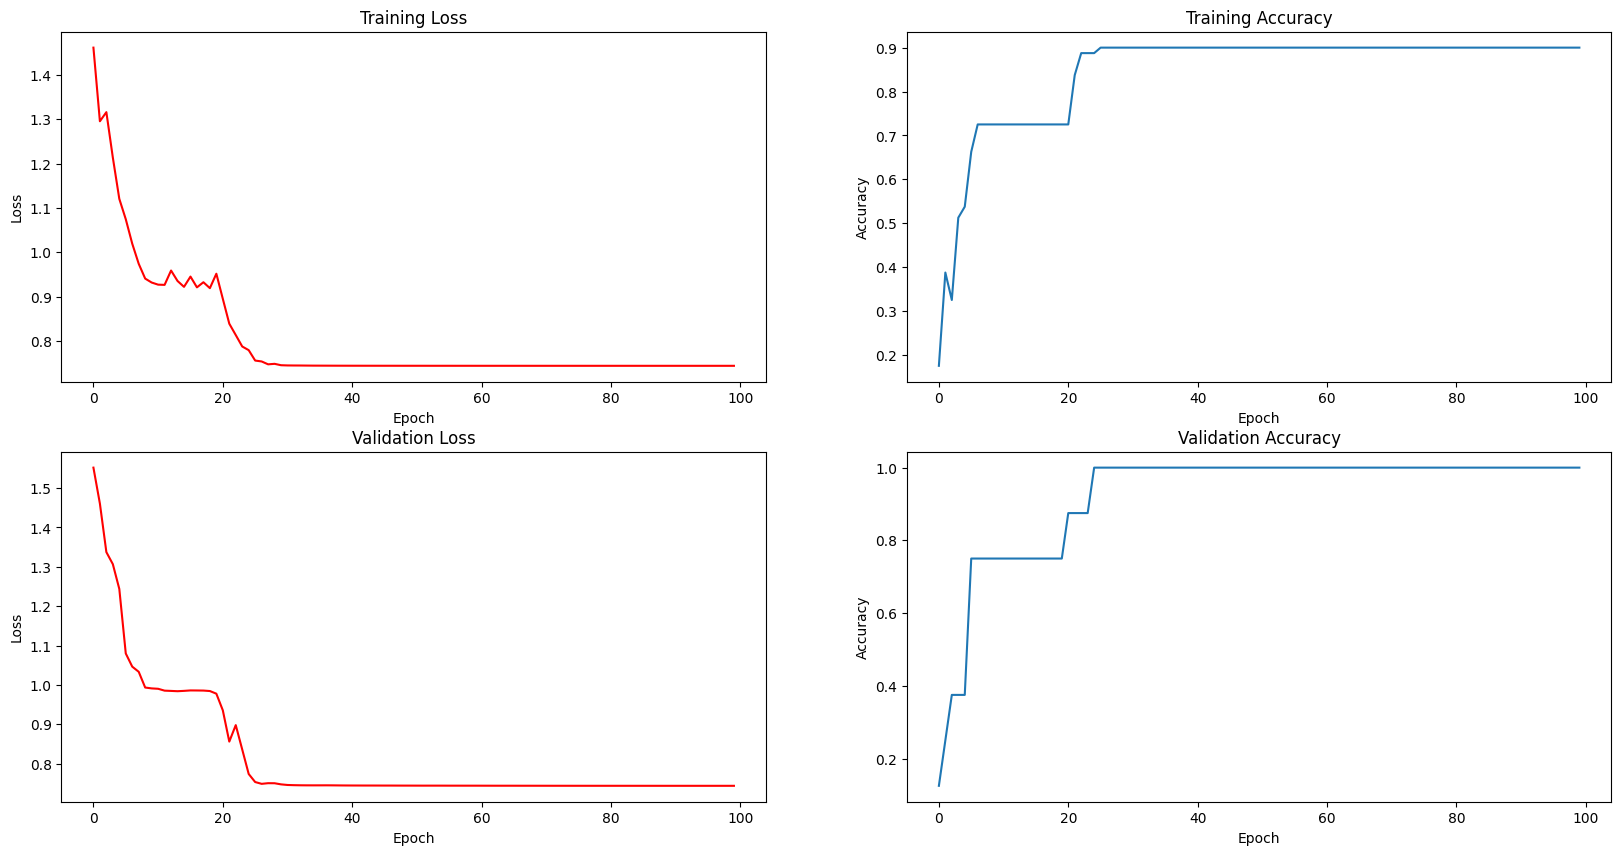

In [5]:
gesture_recognizer = VRGestureRecognizer(hidden_size=HIDDEN_SIZE, num_classes=NUM_LABELS).to(Hardware.device(), dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

gesture_recognizer.compile(loss_fn)
training_history = gesture_recognizer.fit(X_train, y_train, X_val, y_val, epochs=EPOCHS, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE)

gesture_recognizer.plot_history()

### Evaluation

We can now evaluate the model on the test set. We will use the accuracy and the loss of the model as metrics.

In [6]:
test_loss, test_accuracy = gesture_recognizer.to(Hardware.device()).evaluate(X_test, y_test)
print(f"Loss: {test_loss.item():.2f} | Accuracy: {test_accuracy * 100:.2f}%")

Loss: 0.74 | Accuracy: 100.00%


### Results

Let's first make predictions on our test set.

In [7]:
y_pred = gesture_recognizer.to(Hardware.device()).predict(X_test).cpu().numpy().astype(dtype=np.int32)

#### Confusion matrix

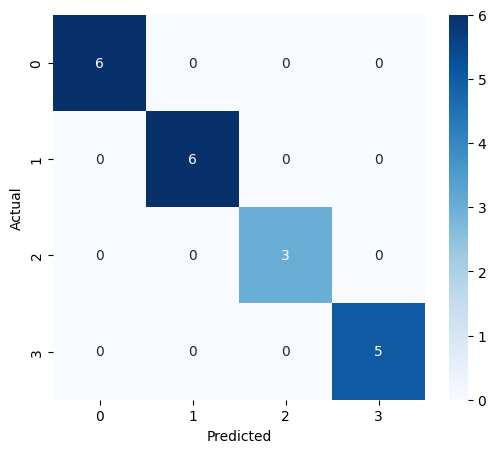

In [8]:
gesture_recognizer_confusion_matrix = confusion_matrix(y_test, y_pred)
Plot.plot_confusion_matrix(gesture_recognizer_confusion_matrix, fig_size=(6, 5))

#### Classification report

In [9]:
print(classification_report(y_test, y_pred, target_names=classes, zero_division=0))

              precision    recall  f1-score   support

         OUI       1.00      1.00      1.00         6
         NON       1.00      1.00      1.00         6
        VRAI       1.00      1.00      1.00         3
        FAUX       1.00      1.00      1.00         5

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



### Exporting the model

In [10]:
gesture_recognizer.export_to_onnx(path='gesture_recognizer.onnx')

================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



### Resetting datasets

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=16)

## XGBoost - Extreme Gradient Boosting

### Model initialization

In [12]:
xgb_classifier = XGBClassifier(
    n_estimators=100,
    max_depth=128,
    learning_rate=0.1,
    objective='multi:softmax',
    num_class=classes.shape[0]
)

### Cross validation

In [13]:
kFold = KFold(n_splits=5, shuffle=True, random_state=20)
scores = cross_val_score(xgb_classifier, X_train.reshape(X_train.shape[0], -1), y_train, cv=kFold, scoring='accuracy')
print(f"Cross validation mean accuracy: {scores.mean() * 100:.2f}%\n")

Cross validation mean accuracy: 97.50%



### Train and predict

In [14]:
xgb_classifier.fit(X_train.reshape(X_train.shape[0], -1), y_train)
y_pred = xgb_classifier.predict(X_test.reshape(X_test.shape[0], -1))

### Results

#### Confusion matrix (heatmap)

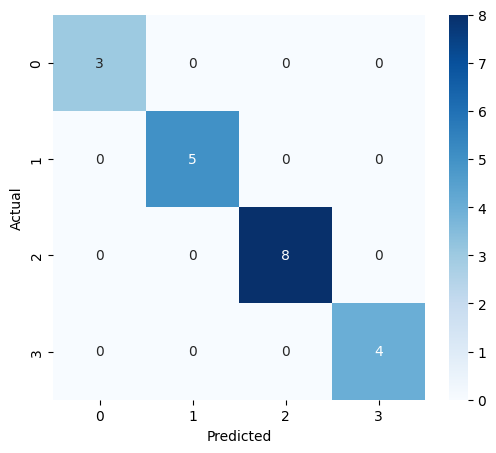

In [15]:
xgb_confusion_matrix = confusion_matrix(y_test, y_pred)
Plot.plot_confusion_matrix(xgb_confusion_matrix, fig_size=(6, 5))

#### Classification report

In [16]:
print(classification_report(y_test, y_pred, target_names=classes, zero_division=0))

              precision    recall  f1-score   support

         OUI       1.00      1.00      1.00         3
         NON       1.00      1.00      1.00         5
        VRAI       1.00      1.00      1.00         8
        FAUX       1.00      1.00      1.00         4

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



## Random Forest Classifier

### Model initialization

In [17]:
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=64,
    class_weight='balanced',
    random_state=16
)

### Cross Validation

In [18]:
kFold = KFold(n_splits=5, shuffle=True, random_state=10)
scores = cross_val_score(rf_classifier, X_train.reshape(X_train.shape[0], -1), y_train, cv=kFold, scoring='accuracy')

print(f"Cross validation mean accuracy: {scores.mean() * 100:.2f}%\n")

Cross validation mean accuracy: 100.00%



### Train and predict

In [19]:
rf_classifier.fit(X_train.reshape(X_train.shape[0], -1), y_train)
y_pred = rf_classifier.predict(X_test.reshape(X_test.shape[0], -1))

### Results

#### Confusion matrix (heatmap)

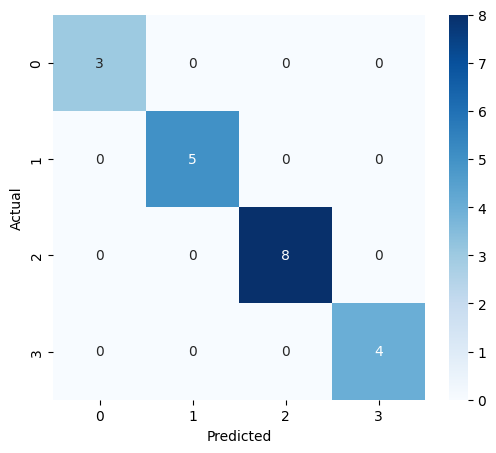

In [20]:
rf_confusion_matrix = confusion_matrix(y_test, y_pred)
Plot.plot_confusion_matrix(rf_confusion_matrix, fig_size=(6, 5))

#### Classification report

In [21]:
print(classification_report(y_test, y_pred, target_names=classes, zero_division=0))

              precision    recall  f1-score   support

         OUI       1.00      1.00      1.00         3
         NON       1.00      1.00      1.00         5
        VRAI       1.00      1.00      1.00         8
        FAUX       1.00      1.00      1.00         4

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



## Decision Tree Classifier

### Model initialization

In [22]:
dt_classifier = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=128,
    class_weight='balanced',
    random_state=42
)

### Cross Validation

In [23]:
kFold = KFold(n_splits=5, shuffle=True, random_state=10)
scores = cross_val_score(dt_classifier, X_train.reshape(X_train.shape[0], -1), y_train, cv=kFold, scoring='accuracy')

print(f"Cross validation mean accuracy: {scores.mean() * 100:.2f}%\n")

Cross validation mean accuracy: 100.00%



### Train and predict

In [24]:
dt_classifier.fit(X_train.reshape(X_train.shape[0], -1), y_train)
y_pred = dt_classifier.predict(X_test.reshape(X_test.shape[0], -1))

### Results

#### Confusion matrix (heatmap)

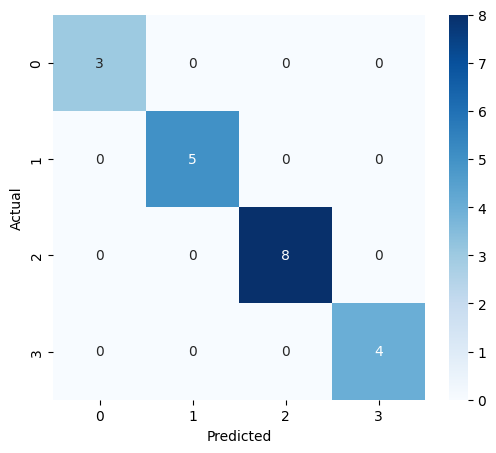

In [25]:
dt_confusion_matrix = confusion_matrix(y_test, y_pred)
Plot.plot_confusion_matrix(dt_confusion_matrix, fig_size=(6, 5))

#### Classification report

In [26]:
print(classification_report(y_test, y_pred, target_names=classes, zero_division=0))

              precision    recall  f1-score   support

         OUI       1.00      1.00      1.00         3
         NON       1.00      1.00      1.00         5
        VRAI       1.00      1.00      1.00         8
        FAUX       1.00      1.00      1.00         4

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

